In [ ]:
# import data handling tools
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder, StandardScaler
from sklearn.decomposition import IncrementalPCA 
from sklearn.neighbors import KNeighborsClassifier
import warnings
import pickle

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [44]:
# Define the dataset path
dataset_path = r"..\Smart System Project\PlantVillage"

data = []
labels = []

# Iterate through the dataset directory and add all classes
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            data.append(img_path)
            labels.append(class_name)

# Create the DataFrame
df = pd.DataFrame({'data': data, 'label': labels})


In [45]:
df

,data,label
0,..\Smart System Project\PlantVillage\Pepper__b...,Pepper__bell___Bacterial_spot
1,..\Smart System Project\PlantVillage\Pepper__b...,Pepper__bell___Bacterial_spot
2,..\Smart System Project\PlantVillage\Pepper__b...,Pepper__bell___Bacterial_spot
3,..\Smart System Project\PlantVillage\Pepper__b...,Pepper__bell___Bacterial_spot
4,..\Smart System Project\PlantVillage\Pepper__b...,Pepper__bell___Bacterial_spot
...,...,...
20634,..\Smart System Project\PlantVillage\Tomato__T...,Tomato__Tomato_YellowLeaf__Curl_Virus
20635,..\Smart System Project\PlantVillage\Tomato__T...,Tomato__Tomato_YellowLeaf__Curl_Virus
20636,..\Smart System Project\PlantVillage\Tomato__T...,Tomato__Tomato_YellowLeaf__Curl_Virus
20637,..\Smart System Project\PlantVillage\Tomato__T...,Tomato__Tomato_YellowLeaf__Curl_Virus


In [4]:
image = Image.open(r"C:\Users\moata\Documents\Projects\Smart System Project\PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG")
width, height = image.size
print(f"Width: {width}, Height: {height}")

Width: 256, Height: 256


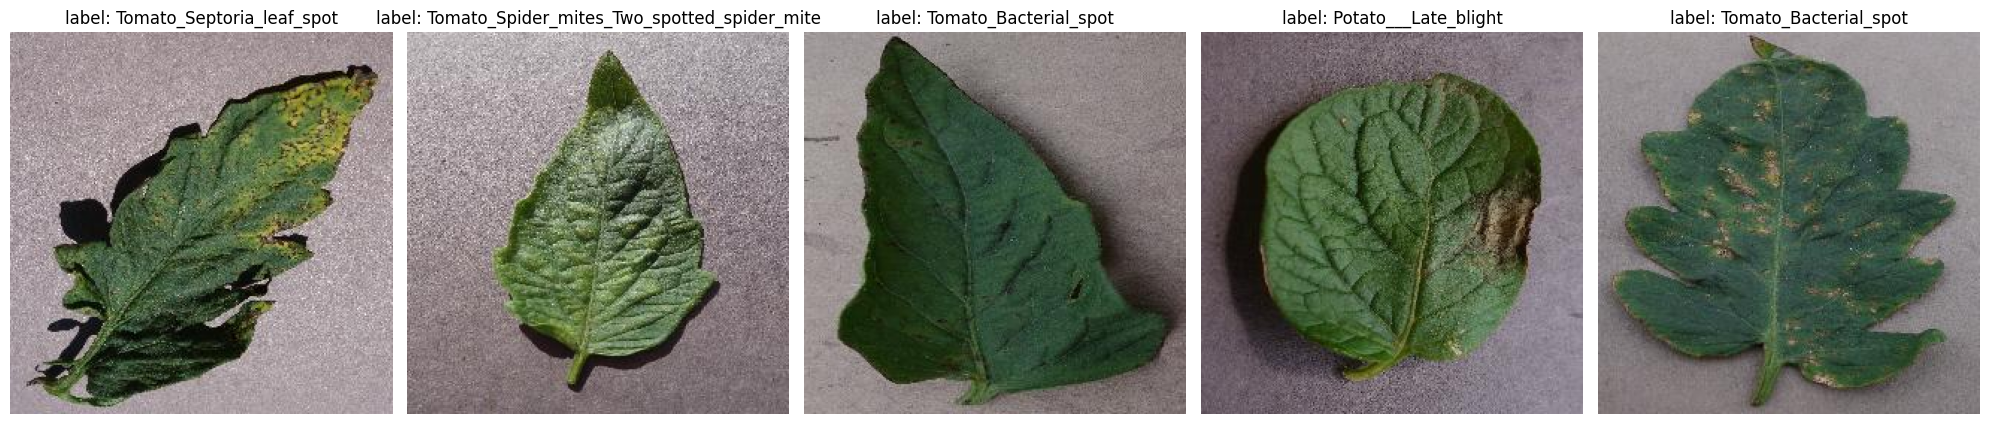

In [5]:
plt.figure(figsize=(20, 15))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    index = np.random.choice(df.index)
    filename = df.loc[index, 'data']
    category = df.loc[index, 'label']
    img = Image.open(filename)
    plt.imshow(img)
    plt.title(f'label: {category}')
    plt.axis('off') 

plt.tight_layout()
plt.show()

In [6]:
def extract_hog_features(image):
    # Convert the image to grayscale using cv2
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    hog = cv2.HOGDescriptor()
    
    # Compute HOG features
    hog_features = hog.compute(gray_image)

    return hog_features.flatten()

In [8]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
batch_size = 32  # Adjust batch size based on memory constraints
features_list = []
labels_list = []

# Resize function to downsample images
def resize_image(image, new_size=(128, 128)):
    return cv2.resize(image, new_size)

for start in range(0, len(df_shuffled), batch_size):
    end = min(start + batch_size, len(df_shuffled))
    batch = df_shuffled[start:end]

    batch_features = []
    batch_labels = []

    for index, row in batch.iterrows():
        image = cv2.imread(row['data'])
        if image is None:
            print(f"Failed to load image: {row['data']}")
            continue
        resized_image = resize_image(image)  # Resize image to smaller dimensions
        hog_features = extract_hog_features(resized_image)
        batch_features.append(hog_features)
        batch_labels.append(row['label'])

    features_list.extend(batch_features)
    labels_list.extend(batch_labels)

Failed to load image: C:\Users\moata\Documents\Projects\Smart System Project\PlantVillage\Tomato__Tomato_YellowLeaf__Curl_Virus\svn-r6Yb5c


In [9]:
# Convert lists to NumPy arrays
features_array = np.array(features_list)
labels_array = np.array(labels_list)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_array)

print("Shape of extracted HOG features:", features_array.shape)

Shape of extracted HOG features: (20638, 34020)


In [10]:
len(labels_encoded)

20638

In [11]:
np.unique(labels_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_encoded, test_size=0.25, random_state=42 , stratify = labels_encoded)

In [13]:
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(type(X_test), X_test.shape)
print(type(y_test), y_test.shape)

<class 'numpy.ndarray'> (15478, 34020)
<class 'numpy.ndarray'> (15478,)
<class 'numpy.ndarray'> (5160, 34020)
<class 'numpy.ndarray'> (5160,)


In [14]:
# Feature Scaling
print("[INFO] Scaling features...")
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

[INFO] Scaling features...


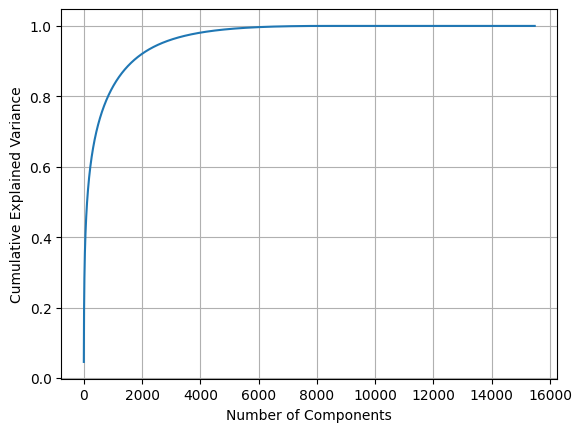

In [ ]:
ipca = IncrementalPCA()
ipca.fit(X_train)
cumulative_variance = np.cumsum(ipca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [46]:
print("[INFO] Performing Dimensionality Reduction with Incremental PCA...")
# ✅ Dimensionality Reduction with Incremental PCA
ipca = IncrementalPCA(n_components=50)
batch_size = 256  # Process 256 samples at a time
ipca.fit(X_train)

# Transform the training and test sets in chunks
X_train_pca = ipca.transform(X_train)
X_test_pca = ipca.transform(X_test)

print(f"Reduced feature space: {X_train_pca.shape}")

[INFO] Performing Dimensionality Reduction with Incremental PCA...
Reduced feature space: (15478, 50)


In [47]:
print("[INFO] Hyperparameter tuning with GridSearchCV...")
# ✅ Updated parameter grid
param_grid = {
    'n_neighbors': [3, 7, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# ✅ Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ✅ Grid Search with all cores and verbosity for better feedback
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, verbose=2, n_jobs=-1)
grid.fit(X_train_pca, y_train)

print("[INFO] Best Parameters found:", grid.best_params_)
print("[INFO] Best Cross-Validation Score:", grid.best_score_)

[INFO] Hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[INFO] Best Parameters found: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
[INFO] Best Cross-Validation Score: 0.5895467182627643


In [48]:
# Predict on test set
y_pred = grid.best_estimator_.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

Test Accuracy: 0.6012
Classification Report:
                                              precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.65      0.38      0.48       249
                     Pepper__bell___healthy       0.85      0.68      0.76       370
                      Potato___Early_blight       0.55      0.82      0.66       250
                       Potato___Late_blight       0.54      0.41      0.47       250
                           Potato___healthy       0.78      0.18      0.30        38
                      Tomato_Bacterial_spot       0.54      0.77      0.63       532
                        Tomato_Early_blight       0.58      0.10      0.18       250
                         Tomato_Late_blight       0.84      0.57      0.68       477
                           Tomato_Leaf_Mold       0.59      0.58      0.59       238
                  Tomato_Septoria_leaf_spot       0.40      0.56      0.47       443
Tomato_Spider_mite

In [27]:
# Transforming Labels
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(labels_encoded)
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))

<Figure size 1000x800 with 0 Axes>

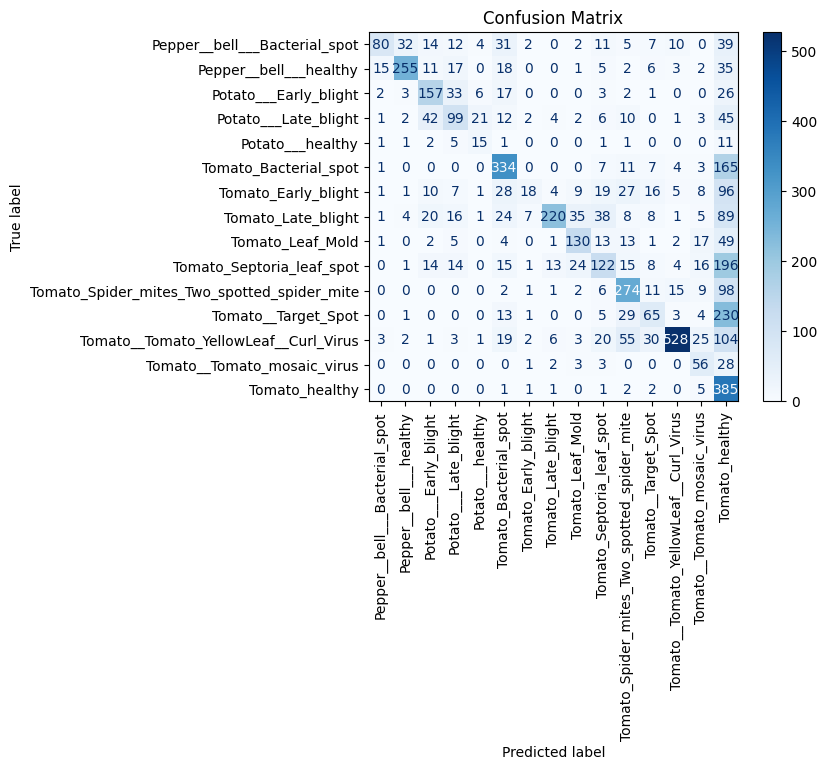

In [30]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
plt.show()